In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from spectral_metric.estimator import CumulativeGradientEstimator
from spectral_metric.visualize import make_graph
print(hasattr(CumulativeGradientEstimator, 'P'))  # Esto debería imprimir True si 'P' está definido correctamente


False


In [3]:
# Lectura de dataset

directorio_dataset = ('../Datasets/CIFAR-10 dos clases')
directorio_dataset = pathlib.Path(directorio_dataset)

imagenes_originales = ('../Datasets/CIFAR-10 dos clases/cat')
imagenes_originales = pathlib.Path(imagenes_originales)

imagenes_corruptas = ('../Datasets/CIFAR-10 dos clases/cat_c_defocus_blur')
imagenes_corruptas = pathlib.Path(imagenes_corruptas)

total_dataset = len(list(directorio_dataset.glob('*/*.png')))  # Cuenta la cantidad de imagenes del dataset (Aqui busca en las subcarpetas del directorio del dataset)
total_originales = len(list(imagenes_originales.glob('*.png')))  # Cuenta la cantidad de imagenes de la clase original (Aqui busca directamente en la carpeta cat)
total_corruptas = len(list(imagenes_corruptas.glob('*.png')))  # Cuenta la cantidad de imagenes de la clase corrupta (Aqui busca directamente en la carpeta cat_c_defocus_blur)

print(f"Total imagenes dataset: {total_dataset}")
print(f"Total imagenes originales: {total_originales}")
print(f"Total imagenes corruptas: {total_corruptas}")

Total imagenes dataset: 10000
Total imagenes originales: 5000
Total imagenes corruptas: 5000


In [4]:
# Dimensiones de imagen y tamaño de batch
img_height = 32
img_width = 32
#batch_size = len(list(data_dir.glob('*/*.png'))) # leer todas las imágenes al tiempo
batch_size = total_dataset

In [5]:
import tensorflow as tf
import pathlib

# Data splitting (entrenamiento y validación)
all_images_in_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  directorio_dataset,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.


In [6]:
class_names = all_images_in_dataset.class_names
num_classes = len(class_names)  # get the number of the classes
print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")

Número de clases: 2
Los nombres de las clases son: ['cat', 'cat_c_defocus_blur']


In [7]:
for images, labels0 in all_images_in_dataset.take(1):  # only take first element of dataset
    numpy_all_images = images.numpy()  # convertir el tensor de imágenes en un arreglo de numpy y ahora contiene las imágenes del conjunto de datos en formato de numpy.
    numpy_all_labels = labels0.numpy()  # convierte el tensor de etiquetas en un arreglo de numpy y ahora contiene las etiquetas del conjunto de datos en formato de numpy

numpy_all_images /= 255.0  # Scale the features to the [0, 1] range
print(numpy_all_images.shape)

(10000, 32, 32, 3)


c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\spectral_metric\visualize.py:48: RuntimeWarning: divide by zero encountered in divide
  similarities = difference.max() / difference * 100
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\spectral_metric\visualize.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


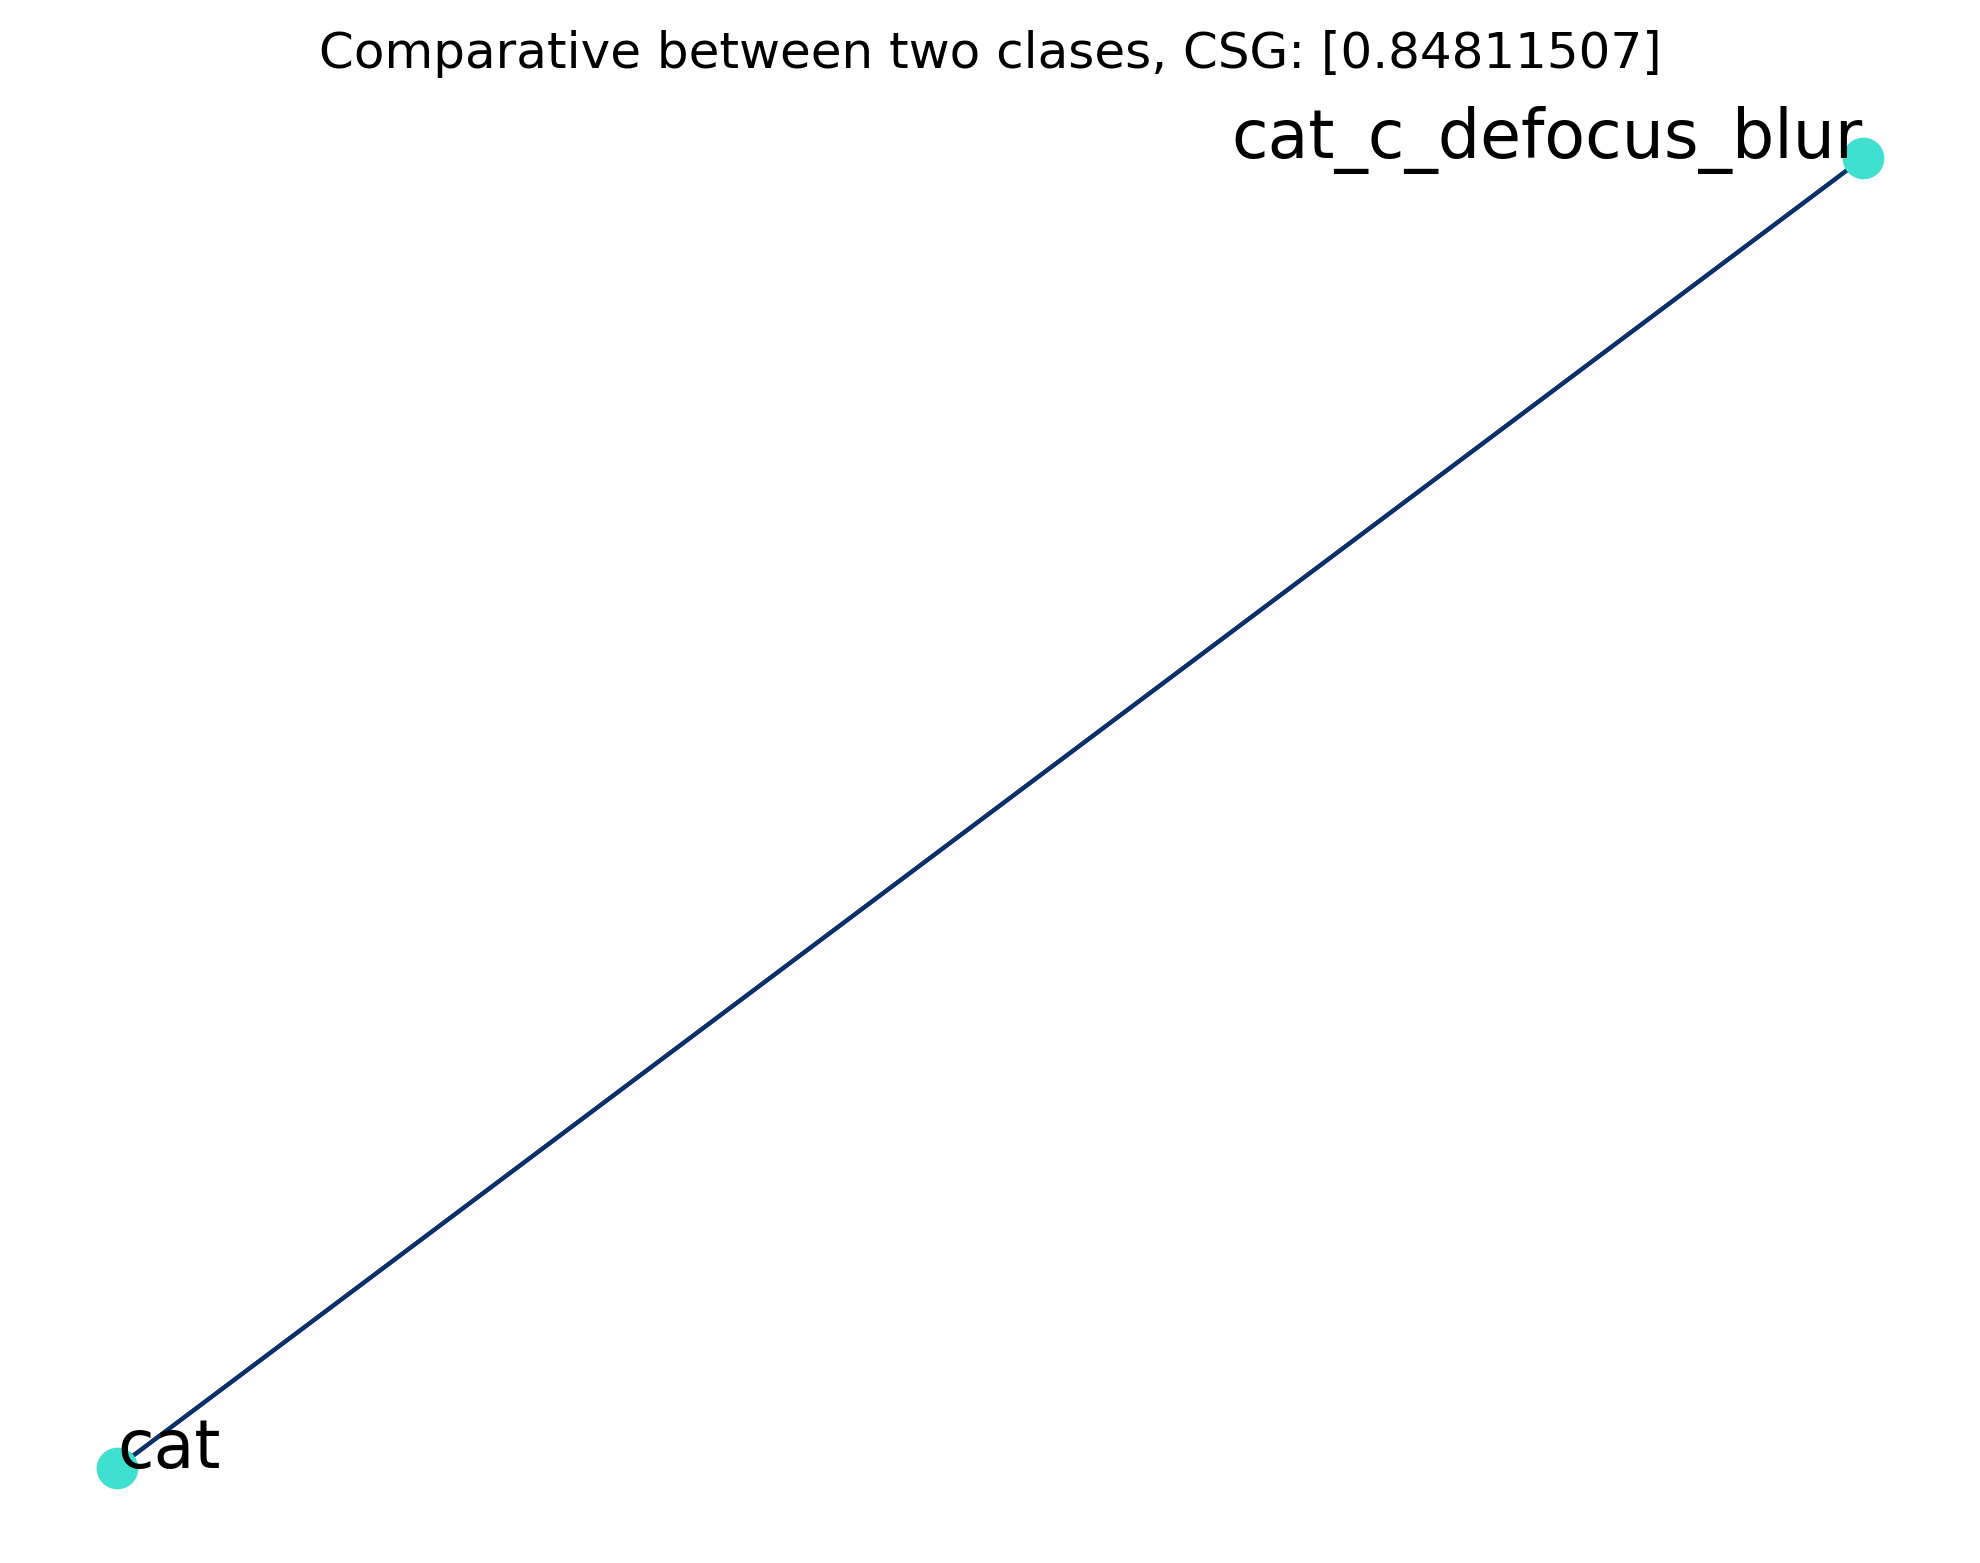

In [8]:
# Aplanar las imágenes
fully_dataset = numpy_all_images.reshape((numpy_all_images.shape[0], numpy_all_images.shape[1]*numpy_all_images.shape[2]*numpy_all_images.shape[3])) # es un arreglo bidimensional donde cada fila representa una imagen y cada columna representa un píxel de la imagen
fully_labels = numpy_all_labels.reshape(numpy_all_labels.shape[0],)


# Inicializar el estimador
estimator = CumulativeGradientEstimator(M_sample=10000, k_nearest=10)
estimator.fit(data=fully_dataset, target=fully_labels)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="Comparative between two clases, CSG: "+str(csg), classes=class_names)

In [9]:
# Ordena los pares de clases en orden de similitud ascendente (menos similar primero)
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))
pairs = [(original,corrupto) for original,corrupto in pairs if original != corrupto]

similitud_de_clases = pairs[0]
original, corrupto = similitud_de_clases  # Pares de clases menos similares

print("Calculo de similitud entre clases")
lst = []
for idx, (original,corrupto) in enumerate(pairs[::2][:1]):
    lst.append({"Clases a comparar" : f"{class_names[original]} <> {class_names[corrupto]}", "Similitud": estimator.W[original,corrupto]})
print(pd.DataFrame(lst))
print(estimator.W.shape)

Calculo de similitud entre clases
           Clases a comparar  Similitud
0  cat <> cat_c_defocus_blur   0.848115
(2, 2)


In [10]:
# Obtener índices de clases
class_original_samples = class_names.index('cat')
class_corrupto_samples = class_names.index('cat_c_defocus_blur')

# Seleccionar muestras de cada clase
original_samples = fully_dataset[fully_labels == class_original_samples] # Esta línea está seleccionando todas las muestras en fully_dataset donde la etiqueta correspondiente en fully_labels es igual a original
corrupto_samples = fully_dataset[fully_labels == class_corrupto_samples] # Esta línea está seleccionando todas las muestras en fully_dataset donde la etiqueta correspondiente en fully_labels es igual a corrupto. Es decir, está seleccionando todas las muestras de la clase corrupta.

# Verifica los tamaños de los índices
print(f"Total muestras originales: {len(original_samples)}")
print(f"Total muestras corruptas: {len(corrupto_samples)}")

# Seleccionar muestras de cada clase
original_indices = np.where(fully_labels == class_original_samples)[0]
corrupto_indices = np.where(fully_labels == class_corrupto_samples)[0]

# Verifica los tamaños de los índices
print(f"Total muestras originales: {len(original_indices)}")
print(f"Total muestras corruptas: {len(corrupto_indices)}")

Total muestras originales: 5000
Total muestras corruptas: 5000
Total muestras originales: 5000
Total muestras corruptas: 5000


In [11]:

def show_most_confused(source_intent, target_intent, estimator, class_names, fully_dataset, fully_labels):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener las probabilidades de la clase objetivo
    probabilities = [sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()]
    
    # Ordenar los índices según las probabilidades
    closest_to_second = np.argsort(probabilities)[::-1][:10]
    dataset_indices = estimator.class_indices[source_intent][closest_to_second]
    
    # Verificar que los índices estén dentro de los límites del dataset
    valid_indices = [int(di) for di in dataset_indices if int(di) < len(fully_dataset)]
    
    for di in valid_indices:
        try:
            print(f"\tÍndice de la imagen: {int(di)}, Forma de la imagen: {fully_dataset[int(di)].shape}, Clase: {class_names[fully_labels[int(di)]]}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]    
show_most_confused(first_pair[0], first_pair[1], estimator, class_names, fully_dataset, fully_labels)
show_most_confused(first_pair[1], first_pair[0], estimator, class_names, fully_dataset, fully_labels)

cat <> cat_c_defocus_blur
	Índice de la imagen: 3729, Forma de la imagen: (3072,), Clase: cat
	Índice de la imagen: 3320, Forma de la imagen: (3072,), Clase: cat
	Índice de la imagen: 3853, Forma de la imagen: (3072,), Clase: cat
	Índice de la imagen: 4097, Forma de la imagen: (3072,), Clase: cat
	Índice de la imagen: 1341, Forma de la imagen: (3072,), Clase: cat
	Índice de la imagen: 1989, Forma de la imagen: (3072,), Clase: cat
	Índice de la imagen: 3574, Forma de la imagen: (3072,), Clase: cat
	Índice de la imagen: 1420, Forma de la imagen: (3072,), Clase: cat
	Índice de la imagen: 128, Forma de la imagen: (3072,), Clase: cat
	Índice de la imagen: 1342, Forma de la imagen: (3072,), Clase: cat
cat_c_defocus_blur <> cat
	Índice de la imagen: 8985, Forma de la imagen: (3072,), Clase: cat_c_defocus_blur
	Índice de la imagen: 6727, Forma de la imagen: (3072,), Clase: cat_c_defocus_blur
	Índice de la imagen: 7620, Forma de la imagen: (3072,), Clase: cat_c_defocus_blur
	Índice de la imagen

In [12]:

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_most_confused(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener las probabilidades de la clase objetivo
    probabilities = [sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()]
    
    # Ordenar los índices según las probabilidades
    closest_to_second = np.argsort(probabilities)[::-1][:10]
    dataset_indices = estimator.class_indices[source_intent][closest_to_second]
    
    # Verificar que los índices estén dentro de los límites del dataset
    valid_indices = [int(di) for di in dataset_indices if int(di) < len(filenames_dict)]
    
    for di in valid_indices:
        try:
            print(f"\tNombre del archivo: {filenames_dict[int(di)]}, Clase: {class_names[fully_labels[int(di)]]}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]    
show_most_confused(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_most_confused(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)

cat <> cat_c_defocus_blur
	Nombre del archivo: tabby_s_000004.png, Clase: cat
	Nombre del archivo: tabby_cat_s_001636.png, Clase: cat
	Nombre del archivo: tabby_s_000280.png, Clase: cat
	Nombre del archivo: tabby_s_000930.png, Clase: cat
	Nombre del archivo: domestic_cat_s_001659.png, Clase: cat
	Nombre del archivo: felis_domesticus_s_000430.png, Clase: cat
	Nombre del archivo: tabby_cat_s_002349.png, Clase: cat
	Nombre del archivo: domestic_cat_s_001898.png, Clase: cat
	Nombre del archivo: alley_cat_s_002601.png, Clase: cat
	Nombre del archivo: domestic_cat_s_001661.png, Clase: cat
cat_c_defocus_blur <> cat
	Nombre del archivo: 39819.png, Clase: cat_c_defocus_blur
	Nombre del archivo: 17291.png, Clase: cat_c_defocus_blur
	Nombre del archivo: 26174.png, Clase: cat_c_defocus_blur
	Nombre del archivo: 07401.png, Clase: cat_c_defocus_blur
	Nombre del archivo: 24814.png, Clase: cat_c_defocus_blur
	Nombre del archivo: 02306.png, Clase: cat_c_defocus_blur
	Nombre del archivo: 25825.png, Clas

In [13]:
# Muestras mas similares


# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_most_confused(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener las probabilidades de la clase objetivo
    probabilities = [sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()]
    
    # Ordenar los índices según las probabilidades
    closest_to_second = np.argsort(probabilities)[::-1][:10]
    dataset_indices = estimator.class_indices[source_intent][closest_to_second]
    
    # Verificar que los índices estén dentro de los límites del dataset
    valid_indices = [int(di) for di in dataset_indices if int(di) < len(filenames_dict)]
    
    for di in valid_indices:
        try:
            filename = filenames_dict[int(di)]
            value = probabilities[closest_to_second[np.where(dataset_indices == di)[0][0]]]
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[fully_labels[int(di)]]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]    
show_most_confused(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_most_confused(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)

cat <> cat_c_defocus_blur
	Nombre del archivo: tabby_s_000004.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: tabby_cat_s_001636.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: tabby_s_000280.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: tabby_s_000930.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: domestic_cat_s_001659.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: felis_domesticus_s_000430.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: tabby_cat_s_002349.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: domestic_cat_s_001898.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: alley_cat_s_002601.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: domestic_cat_s_001661.png, Clase: cat, Similitud: 10000.0000
cat_c_defocus_blur <> cat
	Nombre del archivo: 39819.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000
	Nombre del archivo: 17291.png, Clase: cat_c_defocus_blur, Similitud: 6000

In [14]:
# Muestras menos similares - prueba 1

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_least_similar(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener las probabilidades de la clase objetivo
    probabilities = [sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()]
    
    # Ordenar los índices según las probabilidades (de menor a mayor)
    least_similar_to_second = np.argsort(probabilities)[:10]
    dataset_indices = estimator.class_indices[source_intent][least_similar_to_second]
    
    # Verificar que los índices estén dentro de los límites del dataset
    valid_indices = [int(di) for di in dataset_indices if int(di) < len(filenames_dict)]
    
    for di in valid_indices:
        try:
            filename = filenames_dict[int(di)]
            value = probabilities[least_similar_to_second[np.where(dataset_indices == di)[0][0]]]
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[fully_labels[int(di)]]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]
show_least_similar(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)


cat <> cat_c_defocus_blur
	Nombre del archivo: felis_domesticus_s_000013.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_000474.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tomcat_s_002230.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: domestic_cat_s_000132.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_000887.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_000295.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: felis_domesticus_s_000592.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_000722.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_s_001991.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: true_cat_s_001598.png, Clase: cat, Similitud: 0.0000
cat_c_defocus_blur <> cat
	Nombre del archivo: 43572.png, Clase: cat_c_defocus_blur, Similitud: 0.0000
	Nombre del archivo: 00957.png, Clase: cat_c_defocus_blur, Similitud: 0.0000
	Nombre del archivo: 33413.png, Cla

In [15]:
# Muestras menos similares - prueba 2

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

# Función para mostrar las muestras menos similares
def show_least_similar(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener las probabilidades de la clase objetivo
    probabilities = [sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()]
    
    # Verificar si las probabilidades están correctamente calculadas
    if len(probabilities) == 0 or all(p == 0 for p in probabilities):
        print("Las probabilidades no se calcularon correctamente.")
        return
    
    # Ordenar los índices según las probabilidades (de menor a mayor)
    least_similar_to_second = np.argsort(probabilities)[:10]
    dataset_indices = estimator.class_indices[source_intent][least_similar_to_second]
    
    # Verificar que los índices estén dentro de los límites del dataset
    valid_indices = [int(di) for di in dataset_indices if int(di) < len(filenames_dict)]
    
    for di in valid_indices:
        try:
            filename = filenames_dict[int(di)]
            value = probabilities[least_similar_to_second[np.where(dataset_indices == di)[0][0]]]
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[fully_labels[int(di)]]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]
show_least_similar(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)





cat <> cat_c_defocus_blur
	Nombre del archivo: felis_domesticus_s_000013.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_000474.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tomcat_s_002230.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: domestic_cat_s_000132.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_000887.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_000295.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: felis_domesticus_s_000592.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_000722.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_s_001991.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: true_cat_s_001598.png, Clase: cat, Similitud: 0.0000
cat_c_defocus_blur <> cat
	Nombre del archivo: 43572.png, Clase: cat_c_defocus_blur, Similitud: 0.0000
	Nombre del archivo: 00957.png, Clase: cat_c_defocus_blur, Similitud: 0.0000
	Nombre del archivo: 33413.png, Cla

In [16]:
# Muestras menos similares - prueba 3. Compararción de muestras entre par de clases (estimator.P)

import pickle

with open('estimator.pkl', 'rb') as f:
    estimator = pickle.load(f)


# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_least_similar_using_P(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener la matriz de similitud de las muestras entre las clases
    P = estimator.P[(source_intent, target_intent)]
    
    # Ordenar los índices según las similitudes (de menor a mayor)
    least_similar_indices = np.argsort(P, axis=None)[:10]
    
    # Convertir los índices planos a índices 2D
    least_similar_indices_2d = np.unravel_index(least_similar_indices, P.shape)
    
    # Obtener los índices de las muestras en el dataset
    dataset_indices = [estimator.class_indices[source_intent][idx] for idx in least_similar_indices_2d[0]]
    
    # Verificar que los índices estén dentro de los límites del dataset
    valid_indices = [int(di) for di in dataset_indices if int(di) < len(filenames_dict)]
    
    for di in valid_indices:
        try:
            filename = filenames_dict[int(di)]
            value = P[least_similar_indices_2d[0][np.where(np.array(dataset_indices) == di)[0][0]], 
                      least_similar_indices_2d[1][np.where(np.array(dataset_indices) == di)[0][0]]]
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[fully_labels[int(di)]]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]


# Mostrar los menos similares usando la matriz de pares (P)
show_least_similar_using_P(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar_using_P(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)


cat <> cat_c_defocus_blur
	Nombre del archivo: alley_cat_s_000310.png, Clase: cat, Similitud: 0.6723
	Nombre del archivo: alley_cat_s_000181.png, Clase: cat, Similitud: 0.6725
	Nombre del archivo: alley_cat_s_000310.png, Clase: cat, Similitud: 0.6723
	Nombre del archivo: alley_cat_s_000181.png, Clase: cat, Similitud: 0.6725
	Nombre del archivo: alley_cat_s_000841.png, Clase: cat, Similitud: 0.6774
	Nombre del archivo: alley_cat_s_000841.png, Clase: cat, Similitud: 0.6774
	Nombre del archivo: alley_cat_s_000841.png, Clase: cat, Similitud: 0.6774
	Nombre del archivo: alley_cat_s_000310.png, Clase: cat, Similitud: 0.6723
	Nombre del archivo: alley_cat_s_000310.png, Clase: cat, Similitud: 0.6723
	Nombre del archivo: alley_cat_s_000181.png, Clase: cat, Similitud: 0.6725
cat_c_defocus_blur <> cat
	Nombre del archivo: alley_cat_s_001432.png, Clase: cat, Similitud: 0.6723
	Nombre del archivo: alley_cat_s_001432.png, Clase: cat, Similitud: 0.6723
	Nombre del archivo: alley_cat_s_001522.png, Cla

In [17]:
# Obtener los índices de las muestras para cada clase
class_indices = estimator.class_indices
indices_clase_cat= class_indices[0]
indices_clase_defocus_blur = class_indices[1]

# Imprimir las primeras diez muestras de la clase cat
print(f"Clase: {class_names[0]}")
for i in range(10):
    idx = indices_clase_cat[i]
    print(f"\tÍndice: {idx}, Nombre del archivo: {filenames_dict[idx]}")

# Imprimir las primeras diez muestras de la clase cat_c_defocus_blur
print(f"\nClase: {class_names[1]}")
for i in range(10):
    idx = indices_clase_defocus_blur[i] + total_originales  # Ajuste de índices para la clase cat_c_defocus_blur
    print(f"\tÍndice: {idx}, Nombre del archivo: {filenames_dict[idx]}")

Clase: cat
	Índice: 11, Nombre del archivo: alley_cat_s_000128.png
	Índice: 43, Nombre del archivo: alley_cat_s_000862.png
	Índice: 28, Nombre del archivo: alley_cat_s_000440.png
	Índice: 37, Nombre del archivo: alley_cat_s_000731.png
	Índice: 24, Nombre del archivo: alley_cat_s_000415.png
	Índice: 27, Nombre del archivo: alley_cat_s_000429.png
	Índice: 36, Nombre del archivo: alley_cat_s_000724.png
	Índice: 15, Nombre del archivo: alley_cat_s_000195.png
	Índice: 33, Nombre del archivo: alley_cat_s_000547.png
	Índice: 25, Nombre del archivo: alley_cat_s_000417.png

Clase: cat_c_defocus_blur
	Índice: 5066, Nombre del archivo: 00676.png
	Índice: 5085, Nombre del archivo: 00863.png
	Índice: 5096, Nombre del archivo: 00945.png
	Índice: 5063, Nombre del archivo: 00669.png
	Índice: 5065, Nombre del archivo: 00673.png
	Índice: 5052, Nombre del archivo: 00573.png
	Índice: 5079, Nombre del archivo: 00819.png
	Índice: 5081, Nombre del archivo: 00829.png
	Índice: 5067, Nombre del archivo: 00688.p

In [18]:
# Muestras menos similares - prueba 4. Compararción de muestras entre par de clases (estimator.P)

import pickle

with open('estimator.pkl', 'rb') as f:
    estimator = pickle.load(f)

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_least_similar_using_P(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener la matriz de similitud de las muestras entre las clases
    P = estimator.P[(source_intent, target_intent)]
    
    # Ordenar los índices según las similitudes (de menor a mayor)
    least_similar_indices = np.argsort(P, axis=None)
    
    # Convertir los índices planos a índices 2D
    least_similar_indices_2d = np.unravel_index(least_similar_indices, P.shape)
    
    # Conjuntos para almacenar las muestras menos similares sin duplicados
    seen_source_indices = set()
    seen_target_indices = set()
    
    count = 0
    for src_idx, tgt_idx in zip(least_similar_indices_2d[0], least_similar_indices_2d[1]):
        if count >= 10:
            break
        src_filename = filenames_dict[estimator.class_indices[source_intent][src_idx]]
        tgt_filename = filenames_dict[estimator.class_indices[target_intent][tgt_idx]]
        if src_filename not in seen_source_indices and tgt_filename not in seen_target_indices:
            seen_source_indices.add(src_filename)
            seen_target_indices.add(tgt_filename)
            value = P[src_idx, tgt_idx]
            print(f"\tNombre del archivo: {src_filename}, Clase: {class_names[source_intent]}, Similitud: {value:.4f}")
            count += 1

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]

# Mostrar los menos similares usando la matriz de pares (P)
show_least_similar_using_P(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar_using_P(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)


cat <> cat_c_defocus_blur
	Nombre del archivo: alley_cat_s_000310.png, Clase: cat, Similitud: 0.6723
	Nombre del archivo: alley_cat_s_000181.png, Clase: cat, Similitud: 0.6751
	Nombre del archivo: alley_cat_s_000841.png, Clase: cat, Similitud: 0.6774
	Nombre del archivo: alley_cat_s_000843.png, Clase: cat, Similitud: 0.6980
	Nombre del archivo: alley_cat_s_000737.png, Clase: cat, Similitud: 0.7045
	Nombre del archivo: alley_cat_s_000088.png, Clase: cat, Similitud: 0.7063
	Nombre del archivo: alley_cat_s_000731.png, Clase: cat, Similitud: 0.7160
	Nombre del archivo: alley_cat_s_000083.png, Clase: cat, Similitud: 0.7171
	Nombre del archivo: alley_cat_s_000961.png, Clase: cat, Similitud: 0.7258
	Nombre del archivo: alley_cat_s_000031.png, Clase: cat, Similitud: 0.7323
cat_c_defocus_blur <> cat
	Nombre del archivo: alley_cat_s_001432.png, Clase: cat_c_defocus_blur, Similitud: 0.6723
	Nombre del archivo: alley_cat_s_001522.png, Clase: cat_c_defocus_blur, Similitud: 0.6751
	Nombre del archiv

In [19]:
# Muestras menos similares - prueba 5. Compararción de muestras entre par de clases (estimator.P)
import pickle

# Cargar el estimator desde el archivo
with open('estimator.pkl', 'rb') as f:
    estimator = pickle.load(f)

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_least_similar_using_P(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener la matriz de similitud de las muestras entre las clases
    P = estimator.P[(source_intent, target_intent)]
    
    # Ordenar los índices según las similitudes (de menor a mayor)
    least_similar_indices = np.argsort(P, axis=None)
    
    # Convertir los índices planos a índices 2D
    least_similar_indices_2d = np.unravel_index(least_similar_indices, P.shape)
    
    count = 0
    for src_idx, tgt_idx in zip(least_similar_indices_2d[0], least_similar_indices_2d[1]):
        if count >= 10:
            break

        try:
            src_valid_index = estimator.class_indices[source_intent][src_idx]
            tgt_valid_index = estimator.class_indices[target_intent][tgt_idx]
        except IndexError:
            print(f"IndexError: src_idx {src_idx} or tgt_idx {tgt_idx} out of bounds.")
            continue

        if src_valid_index < len(filenames_dict) and tgt_valid_index < len(filenames_dict):
            src_filename = filenames_dict[src_valid_index]
            tgt_filename = filenames_dict[tgt_valid_index]

            value = P[src_idx, tgt_idx]
            print(f"\tNombre del archivo: {src_filename}, Clase: {class_names[source_intent]}, Similitud: {value:.4f}")
            count += 1
        else:
            print(f"src_valid_index {src_valid_index} or tgt_valid_index {tgt_valid_index} out of bounds.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]

# Mostrar los menos similares usando la matriz de pares (P)
show_least_similar_using_P(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar_using_P(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)


cat <> cat_c_defocus_blur
	Nombre del archivo: alley_cat_s_000310.png, Clase: cat, Similitud: 0.6723
	Nombre del archivo: alley_cat_s_000181.png, Clase: cat, Similitud: 0.6725
	Nombre del archivo: alley_cat_s_000310.png, Clase: cat, Similitud: 0.6748
	Nombre del archivo: alley_cat_s_000181.png, Clase: cat, Similitud: 0.6751
	Nombre del archivo: alley_cat_s_000841.png, Clase: cat, Similitud: 0.6774
	Nombre del archivo: alley_cat_s_000841.png, Clase: cat, Similitud: 0.6774
	Nombre del archivo: alley_cat_s_000841.png, Clase: cat, Similitud: 0.6802
	Nombre del archivo: alley_cat_s_000310.png, Clase: cat, Similitud: 0.6822
	Nombre del archivo: alley_cat_s_000310.png, Clase: cat, Similitud: 0.6825
	Nombre del archivo: alley_cat_s_000181.png, Clase: cat, Similitud: 0.6827
cat_c_defocus_blur <> cat
	Nombre del archivo: alley_cat_s_001432.png, Clase: cat_c_defocus_blur, Similitud: 0.6723
	Nombre del archivo: alley_cat_s_001432.png, Clase: cat_c_defocus_blur, Similitud: 0.6725
	Nombre del archiv

In [20]:
# Verificar el contenido de filenames_dict
print(f"Total archivos en filenames_dict: {len(filenames_dict)}")
print(f"Primeros 10 archivos en filenames_dict: {list(filenames_dict.items())[:10]}")


Total archivos en filenames_dict: 10000
Primeros 10 archivos en filenames_dict: [(0, 'alley_cat_s_000009.png'), (1, 'alley_cat_s_000010.png'), (2, 'alley_cat_s_000031.png'), (3, 'alley_cat_s_000044.png'), (4, 'alley_cat_s_000048.png'), (5, 'alley_cat_s_000080.png'), (6, 'alley_cat_s_000083.png'), (7, 'alley_cat_s_000085.png'), (8, 'alley_cat_s_000088.png'), (9, 'alley_cat_s_000117.png')]


In [21]:
import pickle
import numpy as np
from pathlib import Path

# Cargar el estimator desde el archivo
with open('estimator.pkl', 'rb') as f:
    estimator = pickle.load(f)

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_least_similar_using_P(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener la matriz de similitud de las muestras entre las clases
    P = estimator.P[(source_intent, target_intent)]
    
    print(f"Shape of similarity matrix P: {P.shape}")
    
    # Ordenar los índices según las similitudes (de menor a mayor)
    least_similar_indices = np.argsort(P, axis=None)
    
    # Convertir los índices planos a índices 2D
    least_similar_indices_2d = np.unravel_index(least_similar_indices, P.shape)
    
    count = 0
    for src_idx, tgt_idx in zip(least_similar_indices_2d[0], least_similar_indices_2d[1]):
        if count >= 10:
            break
        
        print(f"src_idx: {src_idx}, tgt_idx: {tgt_idx}")
        
        try:
            src_valid_index = estimator.class_indices[source_intent][src_idx]
            tgt_valid_index = estimator.class_indices[target_intent][tgt_idx]
            
            print(f"src_valid_index: {src_valid_index}, tgt_valid_index: {tgt_valid_index}")
            
            if src_valid_index < len(filenames_dict) and tgt_valid_index < len(filenames_dict):
                src_filename = filenames_dict[src_valid_index]
                tgt_filename = filenames_dict[tgt_valid_index]
                
                value = P[src_idx, tgt_idx]
                print(f"\tNombre del archivo: {src_filename}, Clase: {class_names[source_intent]}, Similitud: {value:.4f}")
                count += 1
            else:
                print(f"src_valid_index {src_valid_index} or tgt_valid_index {tgt_valid_index} out of bounds.")
        except IndexError as e:
            print(f"IndexError: {e}. src_idx: {src_idx}, tgt_idx: {tgt_idx}")
        except KeyError as e:
            print(f"KeyError: {e}. src_valid_index: {src_valid_index}, tgt_valid_index: {tgt_valid_index}")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]

# Mostrar los menos similares usando la matriz de pares (P)
show_least_similar_using_P(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar_using_P(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)


cat <> cat_c_defocus_blur
Shape of similarity matrix P: (50, 50)
src_idx: 21, tgt_idx: 36
src_valid_index: 22, tgt_valid_index: 68
	Nombre del archivo: alley_cat_s_000310.png, Clase: cat, Similitud: 0.6723
src_idx: 41, tgt_idx: 36
src_valid_index: 13, tgt_valid_index: 68
	Nombre del archivo: alley_cat_s_000181.png, Clase: cat, Similitud: 0.6725
src_idx: 21, tgt_idx: 16
src_valid_index: 22, tgt_valid_index: 72
	Nombre del archivo: alley_cat_s_000310.png, Clase: cat, Similitud: 0.6748
src_idx: 41, tgt_idx: 16
src_valid_index: 13, tgt_valid_index: 72
	Nombre del archivo: alley_cat_s_000181.png, Clase: cat, Similitud: 0.6751
src_idx: 40, tgt_idx: 5
src_valid_index: 41, tgt_valid_index: 52
	Nombre del archivo: alley_cat_s_000841.png, Clase: cat, Similitud: 0.6774
src_idx: 40, tgt_idx: 10
src_valid_index: 41, tgt_valid_index: 77
	Nombre del archivo: alley_cat_s_000841.png, Clase: cat, Similitud: 0.6774
src_idx: 40, tgt_idx: 12
src_valid_index: 41, tgt_valid_index: 50
	Nombre del archivo: all

In [22]:
# Muestras menos similares usando estimator.M

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_least_similar_using_M(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener la matriz de similitud de todas las muestras
    M = estimator.M
    
    # Ordenar los índices según las similitudes (de menor a mayor)
    least_similar_indices = np.argsort(M, axis=None)[:10]
    
    # Convertir los índices planos a índices 2D
    least_similar_indices_2d = np.unravel_index(least_similar_indices, M.shape)
    
    # Obtener los índices de las muestras en el dataset
    valid_dataset_indices = []
    for idx in least_similar_indices_2d[0]:
        if idx < len(estimator.class_indices[source_intent]):
            valid_dataset_indices.append(estimator.class_indices[source_intent][idx])
    
    # Verificar que los índices estén dentro de los límites del dataset
    valid_indices = [int(di) for di in valid_dataset_indices if int(di) < len(filenames_dict)]
    
    for di in valid_indices:
        try:
            filename = filenames_dict[int(di)]
            value = M[least_similar_indices_2d[0][np.where(np.array(valid_dataset_indices) == di)[0][0]], 
                      least_similar_indices_2d[1][np.where(np.array(valid_dataset_indices) == di)[0][0]]]
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[fully_labels[int(di)]]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]

# Mostrar los menos similares usando la matriz de todas las muestras (M)
show_least_similar_using_M(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar_using_M(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)


cat <> cat_c_defocus_blur
	Nombre del archivo: alley_cat_s_000080.png, Clase: cat, Similitud: 0.5786
	Nombre del archivo: alley_cat_s_000786.png, Clase: cat, Similitud: 0.5786
	Nombre del archivo: alley_cat_s_000181.png, Clase: cat, Similitud: 0.5813
	Nombre del archivo: alley_cat_s_000080.png, Clase: cat, Similitud: 0.5786
	Nombre del archivo: alley_cat_s_000181.png, Clase: cat, Similitud: 0.5813
cat_c_defocus_blur <> cat
	Nombre del archivo: alley_cat_s_001197.png, Clase: cat, Similitud: 0.5786
	Nombre del archivo: alley_cat_s_001436.png, Clase: cat, Similitud: 0.5786
	Nombre del archivo: alley_cat_s_001444.png, Clase: cat, Similitud: 0.5813
	Nombre del archivo: alley_cat_s_001197.png, Clase: cat, Similitud: 0.5786
	Nombre del archivo: alley_cat_s_001444.png, Clase: cat, Similitud: 0.5813


In [23]:
# Muestras menos similares usando estimator.M

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_least_similar_using_M(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener la matriz de similitud de todas las muestras
    M = estimator.M
    
    # Ordenar los índices según las similitudes (de menor a mayor)
    least_similar_indices = np.argsort(M)[:10]
    
    # Validar que los índices estén dentro de los límites de class_indices[source_intent]
    valid_least_similar_indices = [idx for idx in least_similar_indices if idx < len(estimator.class_indices[source_intent])]
    
    # Obtener los índices de las muestras en el dataset
    dataset_indices = [estimator.class_indices[source_intent][idx] for idx in valid_least_similar_indices]
    
    # Verificar que los índices estén dentro de los límites del dataset
    valid_indices = [int(di) for di in dataset_indices if int(di) < len(filenames_dict)]
    
    for di in valid_indices:
        try:
            filename = filenames_dict[int(di)]
            value = M[least_similar_indices[valid_least_similar_indices.index(di)]]
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[fully_labels[int(di)]]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]

# Mostrar los menos similares usando la matriz de todas las muestras (M)
show_least_similar_using_M(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar_using_M(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)


cat <> cat_c_defocus_blur


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Muestras menos similares usando estimator.M

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_least_similar_using_M(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener la matriz de similitud de todas las muestras
    M = estimator.M
    
    # Ordenar los índices según las similitudes (de menor a mayor)
    least_similar_indices = np.argsort(M)[:10]
    
    # Obtener los índices de las muestras en el dataset
    dataset_indices = estimator.class_indices[source_intent][least_similar_indices]
    
    # Verificar que los índices estén dentro de los límites del dataset
    valid_indices = [int(di) for di in dataset_indices if int(di) < len(filenames_dict)]
    
    for di in valid_indices:
        try:
            filename = filenames_dict[int(di)]
            value = M[least_similar_indices[np.where(dataset_indices == di)[0][0]]]
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[fully_labels[int(di)]]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]

# Mostrar los menos similares usando la matriz de todas las muestras (M)
show_least_similar_using_M(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar_using_M(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)


cat <> cat_c_defocus_blur


IndexError: index 118 is out of bounds for axis 0 with size 50

In [ ]:
import numpy as np
import pathlib

# Definir los nombres de las clases disponibles
class_names = ['cat', 'cat_c_defocus_blur']

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_least_similar_samples(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")

    # Obtener las matrices de similitud
    source_similarity = estimator.similarity_arrays[source_intent]
    target_similarity = estimator.similarity_arrays[target_intent]

    # Obtener las probabilidades de la clase objetivo
    source_probabilities = [sample.sample_probability_norm[target_intent] for sample in source_similarity.values()]
    target_probabilities = [sample.sample_probability_norm[source_intent] for sample in target_similarity.values()]

    # Verificar si las probabilidades están correctamente calculadas
    if len(source_probabilities) == 0 or all(p == 0 for p in source_probabilities):
        print("Las probabilidades no se calcularon correctamente para la clase fuente.")
        return
    if len(target_probabilities) == 0 or all(p == 0 for p in target_probabilities):
        print("Las probabilidades no se calcularon correctamente para la clase objetivo.")
        return

    # Ordenar los índices según las probabilidades (de menor a mayor)
    least_similar_source_to_target = np.argsort(source_probabilities)[:10]
    least_similar_target_to_source = np.argsort(target_probabilities)[:10]

    source_indices = estimator.class_indices[source_intent][least_similar_source_to_target]
    target_indices = estimator.class_indices[target_intent][least_similar_target_to_source]

    # Verificar que los índices estén dentro de los límites del dataset
    valid_source_indices = [int(di) for di in source_indices if int(di) < len(filenames_dict)]
    valid_target_indices = [int(di) for di in target_indices if int(di) < len(filenames_dict)]

    print("Muestras menos similares desde la clase fuente a la clase objetivo:")
    for di in valid_source_indices:
        try:
            filename = filenames_dict[int(di)]
            value = source_probabilities[least_similar_source_to_target[np.where(source_indices == di)[0][0]]]
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[fully_labels[int(di)]]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

    print("Muestras menos similares desde la clase objetivo a la clase fuente:")
    for di in valid_target_indices:
        try:
            filename = filenames_dict[int(di)]
            value = target_probabilities[least_similar_target_to_source[np.where(target_indices == di)[0][0]]]
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[fully_labels[int(di)]]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]
show_least_similar_samples(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar_samples(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)


cat <> cat_c_defocus_blur
Muestras menos similares desde la clase fuente a la clase objetivo:
	Nombre del archivo: tabby_s_000473.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: cat_s_000339.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: felis_domesticus_s_000012.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: felis_domesticus_s_000708.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_s_001423.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: true_cat_s_000097.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_002401.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_000722.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: true_cat_s_000493.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: domestic_cat_s_001831.png, Clase: cat, Similitud: 0.0000
Muestras menos similares desde la clase objetivo a la clase fuente:
	Nombre del archivo: 18072.png, Clase: cat_c_defocus_blur, Similitud: 0.0000
	Nombre de

In [ ]:
# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_least_similar_samples(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")

    # Obtener las matrices de similitud
    source_similarity = estimator.similarity_arrays[source_intent]
    target_similarity = estimator.similarity_arrays[target_intent]

    # Obtener las probabilidades de la clase objetivo
    source_probabilities = [sample.sample_probability_norm[target_intent] for sample in source_similarity.values()]
    target_probabilities = [sample.sample_probability_norm[source_intent] for sample in target_similarity.values()]

    # Verificar si las probabilidades están correctamente calculadas
    if len(source_probabilities) == 0 or all(p == 0 for p in source_probabilities):
        print("Las probabilidades no se calcularon correctamente para la clase fuente.")
        return
    if len(target_probabilities) == 0 or all(p == 0 for p in target_probabilities):
        print("Las probabilidades no se calcularon correctamente para la clase objetivo.")
        return

    # Ordenar los índices según las probabilidades (de menor a mayor)
    least_similar_source_to_target = np.argsort(source_probabilities)[:10]
    least_similar_target_to_source = np.argsort(target_probabilities)[:10]

    source_indices = estimator.class_indices[source_intent][least_similar_source_to_target]
    target_indices = estimator.class_indices[target_intent][least_similar_target_to_source]

    # Verificar que los índices estén dentro de los límites del dataset
    valid_source_indices = [int(di) for di in source_indices if int(di) < len(filenames_dict)]
    valid_target_indices = [int(di) for di in target_indices if int(di) < len(filenames_dict)]

    print("Muestras menos similares desde la clase fuente a la clase objetivo:")
    for di in valid_source_indices:
        try:
            filename = filenames_dict[int(di)]
            value = source_probabilities[least_similar_source_to_target[np.where(source_indices == di)[0][0]]]
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[fully_labels[int(di)]]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

    print("Muestras menos similares desde la clase objetivo a la clase fuente:")
    for di in valid_target_indices:
        try:
            filename = filenames_dict[int(di)]
            value = target_probabilities[least_similar_target_to_source[np.where(target_indices == di)[0][0]]]
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[fully_labels[int(di)]]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]
show_least_similar_samples(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar_samples(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)

cat <> cat_c_defocus_blur
Muestras menos similares desde la clase fuente a la clase objetivo:
	Nombre del archivo: tabby_s_000473.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: cat_s_000339.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: felis_domesticus_s_000012.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: felis_domesticus_s_000708.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_s_001423.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: true_cat_s_000097.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_002401.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: tabby_cat_s_000722.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: true_cat_s_000493.png, Clase: cat, Similitud: 0.0000
	Nombre del archivo: domestic_cat_s_001831.png, Clase: cat, Similitud: 0.0000
Muestras menos similares desde la clase objetivo a la clase fuente:
	Nombre del archivo: 18072.png, Clase: cat_c_defocus_blur, Similitud: 0.0000
	Nombre de

In [ ]:
# Supongamos que class_names es un diccionario que mapea índices de clases a nombres de clases
class_names = {0: 'cat', 1: 'cat_c_defocus_blur'}

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo
filenames_dict = {i: filenames[i] for i in range(len(filenames))}

def show_most_confused(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener las probabilidades de la clase objetivo
    probabilities = [sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()]
    
    # Ordenar los índices según las probabilidades
    closest_to_second = np.argsort(probabilities)[::-1][:10]
    dataset_indices = estimator.class_indices[source_intent][closest_to_second]
    
    # Verificar que los índices estén dentro de los límites del dataset
    valid_indices = [int(di) for di in dataset_indices if int(di) < len(filenames_dict)]
    
    for di in valid_indices:
        try:
            print(f"\tNombre del archivo: {filenames_dict[int(di)]}, Clase: {class_names[fully_labels[int(di)]]}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]    
show_most_confused(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_most_confused(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)

cat <> cat_c_defocus_blur
	Nombre del archivo: ..\Datasets\CIFAR-10 dos clases\cat\tabby_cat_s_000754.png, Clase: cat
	Nombre del archivo: ..\Datasets\CIFAR-10 dos clases\cat\felis_domesticus_s_000322.png, Clase: cat
	Nombre del archivo: ..\Datasets\CIFAR-10 dos clases\cat\tabby_cat_s_000548.png, Clase: cat
	Nombre del archivo: ..\Datasets\CIFAR-10 dos clases\cat\mouser_s_001173.png, Clase: cat
	Nombre del archivo: ..\Datasets\CIFAR-10 dos clases\cat\felis_catus_s_001467.png, Clase: cat
	Nombre del archivo: ..\Datasets\CIFAR-10 dos clases\cat\house_cat_s_001374.png, Clase: cat
	Nombre del archivo: ..\Datasets\CIFAR-10 dos clases\cat\tabby_cat_s_002350.png, Clase: cat
	Nombre del archivo: ..\Datasets\CIFAR-10 dos clases\cat\domestic_cat_s_001144.png, Clase: cat
	Nombre del archivo: ..\Datasets\CIFAR-10 dos clases\cat\tabby_s_000325.png, Clase: cat
	Nombre del archivo: ..\Datasets\CIFAR-10 dos clases\cat\cat_s_000980.png, Clase: cat
cat_c_defocus_blur <> cat
	Nombre del archivo: ..\Datas

In [ ]:
"""
# Calcula la similitud entre todas las muestras
similitud_matrix = estimator.W

# Ordena las muestras según su similitud
indices_ordenados = np.unravel_index(np.argsort(similitud_matrix, axis=None), similitud_matrix.shape)

# Filtrar los índices de las muestras menos similares (no diagonales)
indices_menos_similares = [(i, j) for i, j in zip(*indices_ordenados) if i != j][:10]

# Obtener los nombres de archivo correspondientes a las muestras
filenames = [f.name for f in directorio_dataset.glob('*/*.png')]
class_original_indices = np.where(fully_labels == class_original_samples)[0]
class_corrupto_indices = np.where(fully_labels == class_corrupto_samples)[0]

# Imprimir los nombres y los valores de similitud de las muestras menos similares
for (i, j) in indices_menos_similares:
    filename_i = filenames[i]
    filename_j = filenames[j]
    valor_similitud = similitud_matrix[i, j]
    print(f"Muestras: {filename_i} y {filename_j}, Similitud: {valor_similitud:.4f}")
"""



'\n# Calcula la similitud entre todas las muestras\nsimilitud_matrix = estimator.W\n\n# Ordena las muestras según su similitud\nindices_ordenados = np.unravel_index(np.argsort(similitud_matrix, axis=None), similitud_matrix.shape)\n\n# Filtrar los índices de las muestras menos similares (no diagonales)\nindices_menos_similares = [(i, j) for i, j in zip(*indices_ordenados) if i != j][:10]\n\n# Obtener los nombres de archivo correspondientes a las muestras\nfilenames = [f.name for f in directorio_dataset.glob(\'*/*.png\')]\nclass_original_indices = np.where(fully_labels == class_original_samples)[0]\nclass_corrupto_indices = np.where(fully_labels == class_corrupto_samples)[0]\n\n# Imprimir los nombres y los valores de similitud de las muestras menos similares\nfor (i, j) in indices_menos_similares:\n    filename_i = filenames[i]\n    filename_j = filenames[j]\n    valor_similitud = similitud_matrix[i, j]\n    print(f"Muestras: {filename_i} y {filename_j}, Similitud: {valor_similitud:.4f}"

In [ ]:
"""
# Calcular la similitud entre todas las muestras
similarity_matrix = estimator.W

# Crear una máscara para evitar la diagonal
mask = np.eye(similarity_matrix.shape[0], dtype=bool)

# Ordenar las muestras según su similitud, evitando la diagonal
indices_ordenados = np.unravel_index(np.argsort(similarity_matrix[~mask], axis=None), similarity_matrix.shape)
indices_menos_similares = [(i, j) for i, j in zip(*indices_ordenados) if i != j][:10]

# Obtener los nombres de archivo correspondientes a las muestras
filenames = [f.name for f in directorio_dataset.glob('*/*.png')]
class_original_indices = np.where(fully_labels == class_original_samples)[0]
class_corrupto_indices = np.where(fully_labels == class_corrupto_samples)[0]

# Imprimir los nombres y los valores de similitud de las muestras menos similares
for (i, j) in indices_menos_similares:
    filename_i = filenames[i]
    filename_j = filenames[j]
    valor_similitud = similarity_matrix[i, j]
    print(f"Muestras: {filename_i} y {filename_j}, Similitud: {valor_similitud:.4f}")

"""

'\n# Calcular la similitud entre todas las muestras\nsimilarity_matrix = estimator.W\n\n# Crear una máscara para evitar la diagonal\nmask = np.eye(similarity_matrix.shape[0], dtype=bool)\n\n# Ordenar las muestras según su similitud, evitando la diagonal\nindices_ordenados = np.unravel_index(np.argsort(similarity_matrix[~mask], axis=None), similarity_matrix.shape)\nindices_menos_similares = [(i, j) for i, j in zip(*indices_ordenados) if i != j][:10]\n\n# Obtener los nombres de archivo correspondientes a las muestras\nfilenames = [f.name for f in directorio_dataset.glob(\'*/*.png\')]\nclass_original_indices = np.where(fully_labels == class_original_samples)[0]\nclass_corrupto_indices = np.where(fully_labels == class_corrupto_samples)[0]\n\n# Imprimir los nombres y los valores de similitud de las muestras menos similares\nfor (i, j) in indices_menos_similares:\n    filename_i = filenames[i]\n    filename_j = filenames[j]\n    valor_similitud = similarity_matrix[i, j]\n    print(f"Muestras

In [ ]:

# Calcular la matriz de similitud completa entre todas las muestras
similarity_matrix = estimator.W

# Verificar la forma de la matriz de similitud
print(f"Forma de la matriz de similitud: {similarity_matrix.shape}")

# Ordenar las muestras según su similitud
indices_ordenados = np.unravel_index(np.argsort(similarity_matrix, axis=None), similarity_matrix.shape)



Forma de la matriz de similitud: (2, 2)


In [ ]:
# Filtrar los índices de las muestras menos similares, considerando solo los índices de las dos clases
indices_menos_similares = [(muestra_original, muestra_corrupta) for muestra_original, muestra_corrupta in zip(*indices_ordenados) if muestra_original in original_indices and muestra_corrupta in corrupto_indices][:10]

# Obtener los nombres de archivo correspondientes a las muestras
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Mapear los índices globales a los nombres de los archivos
filenames_map = {i: filenames[i] for i in range(len(filenames))}

# Imprimir los nombres y los valores de similitud de las muestras menos similares
for (muestra_original, muestra_corrupta) in indices_menos_similares:
    nombre_original = filenames_map.get(muestra_original, "Desconocido")
    nombre_corrupto = filenames_map.get(muestra_corrupta, "Desconocido")
    valor_similitud = similarity_matrix[muestra_original, muestra_corrupta]
    print(f"Muestras: {nombre_original} y {nombre_corrupto}, Similitud: {valor_similitud:.4f}")

In [ ]:
# Seleccionar muestras de cada clase
original_indices = np.where(fully_labels == class_original_samples)[0]
corrupto_indices = np.where(fully_labels == class_corrupto_samples)[0]

# Definir si se va a usar el CumulativeGradientEstimator
usar_estimador = True  # Cambia esto a False si no deseas usar el estimador

# Definición de funciones
def calculate_csg(image_original, image_corrupto, estimator=None):
    if estimator:
        # Calcular CSG usando CumulativeGradientEstimator
        image_vector_original = image_original.reshape(1, -1)
        image_vector_corrupto = image_corrupto.reshape(1, -1)
        
        # Concatenar las muestras de ambas clases
        combined_images = np.vstack((image_vector_original, image_vector_corrupto))
        
        # Crear etiquetas para las clases
        # Asumiendo que '0' es la etiqueta para la clase original y '1' para la clase corrupta
        labels = np.array([0, 1])
        
        # Ajustar el estimador con las muestras combinadas y sus etiquetas
        estimator.fit(data=combined_images, target=labels)
        
        # Aquí puedes calcular la similitud o disimilitud como prefieras
        # Por ejemplo, podrías devolver alguna medida de similitud o el propio objeto estimator
        return estimator.csg  # O alguna otra medida calculada a partir del estimador
    else:
        # Calcular CSG usando gradiente si no se proporciona un estimador
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.mean(image, axis=2)
        gradient_x = np.gradient(image, axis=1)
        gradient_y = np.gradient(image, axis=0)
        magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        return np.sum(magnitude)


class_original_samples = class_names.index('cat')
class_corrupto_samples = class_names.index('cat_c_defocus_blur')

# Obtener los nombres de archivo correspondientes a las muestras
filenames = [f.name for f in directorio_dataset.glob('*/*.png')]
original_indices = np.where(fully_labels == class_original_samples)[0]
corrupto_indices = np.where(fully_labels == class_corrupto_samples)[0]

# Crear una instancia del estimador si es necesario
estimator = CumulativeGradientEstimator(M_sample=1000, k_nearest=10) if usar_estimador else None


# Cálculos y resultados
for index_original, index_corrupto in zip(original_indices, corrupto_indices):
    csg_value = calculate_csg(fully_dataset[index_original], fully_dataset[index_corrupto], estimator)





AttributeError: 'dict' object has no attribute 'index'

In [ ]:
def calculate_csg(image, estimator):
    # Asegurarse de que la imagen es un arreglo bidimensional
    if image.ndim != 2:
        raise ValueError("La imagen debe ser un arreglo bidimensional")
    
    # Redimensionar la imagen para que sea un vector fila (1, número de píxeles)
    image_vector = image.reshape(1, -1)
    
    # Calcular el CSG para la imagen utilizando el estimador
    estimator.fit(data=image_vector, target=np.array([0]))  # El target puede ser cualquier valor ya que solo hay una imagen
    csg_value = estimator.csg  # El valor de CSG calculado
    return csg_value


# Obtener las muestras de ambas clases

class_original_samples = class_names.index('cat')
class_corrupto_samples = class_names.index('cat_c_defocus_blur')

original_samples = fully_dataset[fully_labels == class_original_samples] # Esta línea está seleccionando todas las muestras en fully_dataset donde la etiqueta correspondiente en fully_labels es igual a original
corrupto_samples = fully_dataset[fully_labels == class_corrupto_samples] # Esta línea está seleccionando todas las muestras en fully_dataset donde la etiqueta correspondiente en fully_labels es igual a corrupto. Es decir, está seleccionando todas las muestras de la clase corrupta.

# Obtener los nombres de archivo correspondientes a las muestras
filenames = [f.name for f in directorio_dataset.glob('*/*.png')]
class_original_indices = np.where(fully_labels == class_original_samples)[0]
class_corrupto_indices = np.where(fully_labels == class_corrupto_samples)[0]

# Crear una instancia del estimador
estimator = CumulativeGradientEstimator(M_sample=1000, k_nearest=10)

# Obtener los nombres de las imágenes menos similares
nombre_imagen_original = class_names[class_original_indices]
nombre_imagen_corrupto = class_names[class_corrupto_indices]

# Imprimir los valores de CSG y los nombres de las imágenes
print(f"El valor de CSG para la imagen original menos similar ({nombre_imagen_original}) es: {csg_original}")
print(f"El valor de CSG para la imagen corrupta menos similar ({nombre_imagen_corrupto}) es: {csg_corrupto}")

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
# Obtener las muestras de ambas clases

class_original_samples = class_names.index('cat')
class_corrupto_samples = class_names.index('cat_c_defocus_blur')

original_samples = fully_dataset[fully_labels == class_original_samples] # Esta línea está seleccionando todas las muestras en fully_dataset donde la etiqueta correspondiente en fully_labels es igual a original
corrupto_samples = fully_dataset[fully_labels == class_corrupto_samples] # Esta línea está seleccionando todas las muestras en fully_dataset donde la etiqueta correspondiente en fully_labels es igual a corrupto. Es decir, está seleccionando todas las muestras de la clase corrupta.

In [ ]:
from scipy.spatial.distance import cdist

# Aqui compara solamente una clase con la otra

# Aplanar las imágenes en vectores unidimensionales
original_samples_flat = original_samples.reshape((original_samples.shape[0], -1))
corrupto_samples_flat = corrupto_samples.reshape((corrupto_samples.shape[0], -1))

# Calcular la matriz de distancias entre las muestras de la clase original y la clase corrupto
dist_original_to_corrupto = cdist(original_samples_flat, corrupto_samples_flat)
# Calcular la matriz de distancias entre las muestras de la clase corrupto y la clase original
dist_corrupto_to_original = cdist(corrupto_samples_flat, original_samples_flat)

# Verificar si hay algún valor en la matriz de distancias que sea diferente de cero
if (dist_original_to_corrupto != 0).any():
    # Calcular la matriz de similitud como el inverso de la distancia
    similarity_matrix_one = 1 / (1 + dist_original_to_corrupto)
else:
    print("No se puede dividir entre cero")


In [ ]:
from scipy.spatial.distance import cdist


# Aplanar las imágenes en vectores unidimensionales
original_samples_flat = original_samples.reshape((original_samples.shape[0], -1))
corrupto_samples_flat = corrupto_samples.reshape((corrupto_samples.shape[0], -1))

# Concatenar las muestras de ambas clases
all_samples = np.concatenate((original_samples_flat, corrupto_samples_flat), axis=0)

# Calcular la matriz de similitud utilizando la distancia euclidiana
similarity_matrix_two = cdist(all_samples, all_samples, metric='euclidean')


In [ ]:
from scipy.spatial.distance import cdist

# Asumiendo que 'fully_dataset' contiene tus muestras
# Calcular la matriz de similitud entre muestras
similarity_matrix_samples = cdist(fully_dataset, fully_dataset, metric='euclidean')

# Invertir los valores para que las distancias más cortas tengan valores más altos (más similares)
similarity_matrix_samples = 1 / (1 + similarity_matrix_samples)

# Encontrar las muestras menos similares
min_index_samples = np.unravel_index(np.argmin(similarity_matrix_samples, axis=None), similarity_matrix_samples.shape)


In [ ]:
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh

# Calcular el Laplaciano del grafo de similitud
laplacian_matrix = laplacian(similarity_matrix_samples, normed=True)

# Calcular los valores propios del Laplaciano
eigenvalues, _ = eigsh(laplacian_matrix)

# Ordenar los valores propios de menor a mayor
eigenvalues = np.sort(eigenvalues)

# Calcular el gradiente de los valores propios ordenados
gradients = np.gradient(eigenvalues)

# Sumar los gradientes para obtener el CSG
csg = np.sum(gradients)

print(csg)

0.00032344967689978965


In [ ]:
# Obtener los nombres de archivo correspondientes a las muestras
filenames = [f.name for f in directorio_dataset.glob('*/*.png')]
class_original_indices = np.where(fully_labels == class_original_samples)[0]
class_corrupto_indices = np.where(fully_labels == class_corrupto_samples)[0]

# Encontrar el índice del valor más bajo en la matriz de similitud
min_index = np.unravel_index(np.argmin(similarity_matrix_samples, axis=None), similarity_matrix_samples.shape)

# Calcular el número total de muestras por clase
num_samples_per_class = similarity_matrix_samples.shape[0] // 2

# Mapear los índices a las listas de índices de clase correctas
if min_index[0] < num_samples_per_class:
    index_original = class_original_indices[min_index[0]]
else:
    index_original = class_original_indices[min_index[0] - num_samples_per_class]

if min_index[1] < num_samples_per_class:
    index_corrupto = class_corrupto_indices[min_index[1]]
else:
    index_corrupto = class_corrupto_indices[min_index[1] - num_samples_per_class]

# Ahora puedes usar 'index_original' y 'index_corrupto' para obtener los nombres de archivo correctos
filename_original = filenames[index_original]
filename_corrupto = filenames[index_corrupto]



In [ ]:

print(f"El nombre de la imagen original menos similar es: {filename_original}")
print(f"El nombre de la imagen corrupta menos similar es: {filename_corrupto}")


El nombre de la imagen original menos similar es: cat_s_001627.png
El nombre de la imagen corrupta menos similar es: 09246.png


In [ ]:
import numpy as np

def calculate_csg(image):
    # Convertir la imagen a escala de grises si es necesario
    if image.ndim == 3 and image.shape[2] == 3:
        image = np.mean(image, axis=2)
    
    # Calcular el gradiente de la imagen
    gradient_x = np.gradient(image, axis=1)
    gradient_y = np.gradient(image, axis=0)
    
    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Calcular el CSG como la suma acumulativa de la magnitud del gradiente
    csg_value = np.sum(magnitude)
    
    return csg_value

# Luego puedes usar esta función para calcular el CSG de tus imágenes
csg_original = calculate_csg(fully_dataset[index_original])
csg_corrupto = calculate_csg(fully_dataset[index_corrupto])

# Imprimir los valores de CSG
print(f"El valor de CSG para la imagen original menos similar es: {csg_original}")
print(f"El valor de CSG para la imagen corrupta menos similar es: {csg_corrupto}")


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# Suponiendo que tienes una función que calcula el CSG llamada 'calculate_csg'
# y que 'fully_dataset' es tu conjunto de datos completo con todas las imágenes

# Calcular el CSG para la imagen original menos similar
csg_original = calculate_csg(fully_dataset[index_original])

# Calcular el CSG para la imagen corrupta menos similar
csg_corrupto = calculate_csg(fully_dataset[index_corrupto])

# Imprimir los valores de CSG
print(f"El valor de CSG para la imagen original menos similar es: {csg_original}")
print(f"El valor de CSG para la imagen corrupta menos similar es: {csg_corrupto}")
